In [1]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# Fit a mesh via rendering

This tutorial shows how to:
- Load a mesh and textures from an `.obj` file. 
- Create a synthetic dataset by rendering a textured mesh from multiple viewpoints
- Fit a mesh to the observed synthetic images using differential silhouette rendering
- Fit a mesh and its textures using differential textured rendering

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [2]:
import json
from collections import defaultdict
import time
import itertools
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git'


In [3]:
import os
import torch
import matplotlib.pyplot as plt
%matplotlib inline


from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
    AmbientLights
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

import wandb



If using **Google Colab**, fetch the utils file for plotting image grids:

In [4]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
# from plot_image_grid import image_grid

OR if running **locally** uncomment and run the following cell:

In [5]:
 # from plot_image_grid import image_grid

### 1. Load a mesh and texture file

Load an `.obj` file and its associated `.mtl` file and create a **Textures** and **Meshes** object. 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes. 

**TexturesVertex** is an auxiliary datastructure for storing vertex rgb texture information about meshes. 

**Meshes** has several class methods which are used throughout the rendering pipeline.

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path. 

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [7]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles. 

#tohle jsou 2 hodnoty, ktere upravuji odkud se na objekt divam
#jedna se hybe "zprava doleva", druha se hybe "zespod nahoru"
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)


# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction.

#nastaveni svetel, pri reseni hodnot textury mimo 0-1 zkousim zmenit nastaveni svetel:

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
# lights = AmbientLights(device=device)


# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)

cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=128, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct=False,
    max_faces_per_bin=100000
)


# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device, 
        cameras=camera,
        lights=lights)
)

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


In [8]:
# Path to dataset
DATA_DIR = "./my_data/3DDataset_stuff/dataset2/"

data_to_load = []


for dire in os.listdir(DATA_DIR):
    obj_filename = os.path.join(DATA_DIR, dire, 'normalized_model.obj')
    if dire[0] != '.':
        data_to_load.append(obj_filename)
        
data_to_load = data_to_load[:2]
    

# obj_filename = os.path.join(DATA_DIR, "test2/normalized_model.obj")

def load_mesh_and_target_rgb(obj_filename):
    # Load obj file
    mesh = load_objs_as_meshes([obj_filename], device=device)

    # We scale normalize and center the target mesh to fit in a sphere of radius 1 
    # centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
    # to its original center and scale.  Note that normalizing the target mesh, 
    # speeds up the optimization but is not necessary!
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-center)
    mesh.scale_verts_((1.0 / float(scale)))
    
    
    # Create a batch of meshes by repeating the cow mesh and associated textures. 
    # Meshes has a useful `extend` method which allows us do this very easily. 
    # This also extends the textures. 
    meshes = mesh.extend(num_views)

    # Render the cow mesh from each viewing angle

    target_images = renderer_textured(meshes, cameras=cameras, lights=lights)



    # Our multi-view cow dataset will be represented by these 2 lists of tensors,
    # each of length num_views.
    #list 20 tensoru [128,128,4]
    target_rgb = [target_images[i, ..., :3] for i in range(num_views)]

    target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]


    return mesh, target_images, target_cameras




# cow = os.path.join(DATA_DIR, 'cow_mesh/normalized_model.obj')
# print(cow)

# _, target_images, _ = load_mesh_and_target_rgb(cow)





Visualize the dataset:

In [9]:
# image_grid(target_images.cpu().detach().numpy(), rows=4, cols=5, rgb=True)
# plt.show()

Later in this tutorial, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object.  We construct a soft silhouette shader to render this alpha channel.

## 3. Mesh prediction via silhouette rendering
In the previous section, we created a dataset of images of multiple viewpoints of a cow.  In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [10]:
# Show a visualization comparing the rendered predicted mesh to the ground truth 
# mesh
def visualize_prediction(predicted_mesh, renderer, 
                         target_image, title='', 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")
    

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

We create a new differentiable renderer for rendering the silhouette of our predicted mesh:

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the silhouettes of the target images:

## 3. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

Initial texture
3 functions defining possible start textures

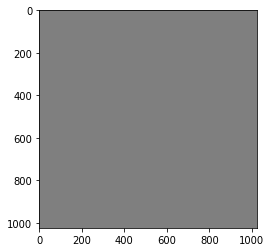

In [11]:

def checkerboard_texture(device):
    texture = np.indices((1024,1024)).sum(axis=0) % 2
    texture = np.repeat(texture[:, :, np.newaxis], 3, axis=2)
    texture = np.expand_dims(texture, axis=0)
    texture = texture.astype(np.float32)
    return torch.tensor(texture, device=device, requires_grad=True)

def homogeneous_texture(value, device):
    return torch.full((1, 1024,1024, 3), value, device=device, requires_grad=True)

def uniform_distribution_texture(device):
    texture = torch.rand((1,1024,1024,3), device=device, requires_grad=True)
    return texture
    
    
def visualize_texture(tex):
    to_vis = torch.squeeze(tex)
    plt.imshow(to_vis.detach().cpu().numpy())
    plt.show()
    


def visualize_target(i):
    ith_rgb_img = target_rgb[i]
    plt.imshow(ith_rgb_img.cpu().detach().numpy())
    plt.show()

def visualize_mesh(cam_id=1):
    test = renderer_textured(mesh, cameras=target_cameras[cam_id], lights=lights)
    plt.imshow(torch.squeeze(test).cpu().detach().numpy()[..., :3])
    plt.show()


origin_texture = checkerboard_texture(device)
visualize_texture(origin_texture)



Optimization - hyperparameter tuning.

In [12]:

# Number of views to optimize over in each SGD iteration
num_views_per_iteration = num_views
# Number of optimization steps

Niter = 100000

exec_time = 5

learning_rate = 1.0
momentum = 0.9

loss_rgb_mult = 30000.0
loss_penalization_mult = 0.27

'''
LOSS function

rgb loss: computes MSE between target view and view rendered with predicted texture

penalization loss: the optimization might be ambiguous, probably because the final rasterization is averageing colours, so the colors 
in texture can have RGB components out of range 0-1 for floats, so I use also loss to penalize values out of desired rgb range

'''

losses = {"rgb": {"weight": loss_rgb_mult, "values": []}, "penalization": {"weight": loss_penalization_mult, "values": []}}

def texture_and_optimizer():
    texture = checkerboard_texture(device)
    optimizer = torch.optim.SGD([texture], lr = learning_rate, momentum=momentum)
    return texture, optimizer

'''
Parameter grid

All combinations of parameters will be tried. Time complexity grows exponentially with number of parameters. 

'''
param_grid = {
             "loss_rgb" : [15000], 
             "loss_penalization" : [0.15],
             "learning_rate": [1.0],
             "momentum": [0.9]
             }


# param_grid = {"learning_rate" : [1.0], 
#               "momentum" : [0.9], 
#               "loss_rgb" : [15000], 
#               "loss_penalization" : [0.15, 0.30]}
             
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]


results = torch.empty(len(permutations_dicts), len(losses) * len(data_to_load), requires_grad=False)

a_file = open("param_dict.json", "w")
json.dump(permutations_dicts, a_file)
a_file.close()


print(data_to_load)





['./my_data/3DDataset_stuff/dataset2/c5aaf107-c8d0-4b01-b51d-9c2bddef8e2a/normalized_model.obj']


In [15]:

row_index = 0


for params in permutations_dicts:
    losses["rgb"]["weight"] = params["loss_rgb"]
    losses["penalization"]["weight"]  = params["loss_penalization"]
    learning_rate = params["learning_rate"]
    momentum = params["momentum"]
    column_index = 0
    
    print(params)
    
    for data in data_to_load:
        

        loop = tqdm(range(Niter))

        # wandb.init(project="generating-textures-with-a-gan", 
        #            config = {
        #               "object" : "test2",
        #               "learning_rate": learning_rate,
        #               "momentum:": momentum,
        #               "epochs": Niter,
        #               "loss_rgb_mult": loss_rgb_mult, 
        #               "loss_penalization_mult": loss_penalization_mult,
        #               "data_name" : data
        #             }
        #           )

        origin_texture, my_optimizer = texture_and_optimizer()
        
        # torch.cuda.empty_cache()


        

        mesh, target_images, target_cameras = load_mesh_and_target_rgb(data)
        
        # torch.cuda.empty_cache()






        target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
        
        
        

        for k in range(len(target_rgb)):
            target_rgb[k] = torch.unsqueeze(target_rgb[k], 0)

        target_rgb = torch.cat(target_rgb, 0)
        
        # print(target_rgb.size())
        # target_rgb = torch.permute(target_rgb, (0, 3, 1, 2))
    
    
    
    
        start_time = time.time()
        

        for i in loop:
            print(i)
            start = time.time()

            
            # torch.cuda.empty_cache()


            my_optimizer.zero_grad()
            
            #mesh namapuji na novou texturu
            mesh.textures._maps_padded = origin_texture
            # meshes = mesh.extend(num_views)
            meshes = mesh.extend(num_views)


            loss = {k: torch.tensor(0.0, device=device) for k in losses}

            
            
            pred_list = []
            

            pred_list = renderer_textured(meshes, cameras=cameras, lights=lights)




    
            pred_list = pred_list[..., :3]
            
#                 #compute rgb rgb loss

            print(f'rendertime: {time.time() - start}')


            loss_rgb = torch.mean(((pred_list - target_rgb) ** 2), dim=(1,2,3))
            loss_rgb = torch.sum(loss_rgb)
            loss["rgb"] = loss_rgb / num_views_per_iteration
            
            
            

            #compute loss of values below 0
            penalization_bellow_0 = origin_texture[origin_texture<0.0]
            penalization_bellow_0 = -torch.sum(penalization_bellow_0)

            #compute loss of values above 1
            penalization_above_1 = origin_texture[origin_texture>1.0]
            penalization_above_1 = torch.sum(penalization_above_1 - 1)

            #add those two losses together and normalize
            penalization = penalization_bellow_0 + penalization_above_1
            loss["penalization"] = penalization/num_views_per_iteration




            #Weighted sum of the losses
            sum_loss = torch.tensor(0.0, device=device)
            for k, l in loss.items():
                sum_loss += l * losses[k]["weight"]
                losses[k]["values"].append(float(l.detach().cpu()))

            # wandb.log({"loss_rgb": loss["rgb"], "loss_penalization": loss["penalization"], "sum_loss": sum_loss.item()})


            # Print the losses
            # loop.set_description("total_loss = %.6f" % sum_loss)
            print(sum_loss)


            # Optimization step
            sum_loss.backward()
            torch.nn.utils.clip_grad_norm_(origin_texture, 0.5)
            my_optimizer.step()

            if time.time() - start_time > exec_time:
                print('Time over')
                break

            if torch.isinf(sum_loss).item():
                print('Infinity loss')
                break

                
        results[row_index, column_index] = loss["rgb"]
        results[row_index, column_index + 1] = loss["penalization"]
        
        column_index += 2
        
        print(column_index)
        
    row_index += 1
    column_index = 0
    
torch.save(results, 'results.pt')





{'loss_rgb': 15000, 'loss_penalization': 0.15, 'learning_rate': 1.0, 'momentum': 0.9}


  0%|          | 0/100000 [00:00<?, ?it/s]

0
rendertime: 0.20886945724487305
tensor(73.5411, device='cuda:0', grad_fn=<AddBackward0>)
1
rendertime: 0.20652055740356445
tensor(72.7752, device='cuda:0', grad_fn=<AddBackward0>)
2
rendertime: 0.2063591480255127
tensor(71.5813, device='cuda:0', grad_fn=<AddBackward0>)
3
rendertime: 0.2065129280090332
tensor(70.1942, device='cuda:0', grad_fn=<AddBackward0>)
4
rendertime: 0.20641851425170898
tensor(68.7554, device='cuda:0', grad_fn=<AddBackward0>)
5
rendertime: 0.20640897750854492
tensor(67.3728, device='cuda:0', grad_fn=<AddBackward0>)
6
rendertime: 0.20583558082580566
tensor(65.9424, device='cuda:0', grad_fn=<AddBackward0>)
7
rendertime: 0.20608758926391602
tensor(64.3638, device='cuda:0', grad_fn=<AddBackward0>)
8
rendertime: 0.20616650581359863
tensor(62.6482, device='cuda:0', grad_fn=<AddBackward0>)
9
rendertime: 0.20581340789794922
tensor(60.8806, device='cuda:0', grad_fn=<AddBackward0>)
10
rendertime: 0.20585131645202637
tensor(59.0947, device='cuda:0', grad_fn=<AddBackward0>)


: 

In [15]:
row_index = 0


for params in permutations_dicts:
    losses["rgb"]["weight"] = params["loss_rgb"]
    losses["penalization"]["weight"]  = params["loss_penalization"]
    learning_rate = params["learning_rate"]
    momentum = params["momentum"]
    column_index = 0
    
    print(params)
    
    for data in data_to_load:
        
        print(data)

        loop = tqdm(range(Niter))

        # wandb.init(project="generating-textures-with-a-gan", 
        #            config = {
        #               "object" : "test2",
        #               "learning_rate": learning_rate,
        #               "momentum:": momentum,
        #               "epochs": Niter,
        #               "loss_rgb_mult": loss_rgb_mult, 
        #               "loss_penalization_mult": loss_penalization_mult,
        #               "data_name" : data
        #             }
        #           )

        origin_texture, my_optimizer = texture_and_optimizer()

        mesh, target_images, target_cameras = load_mesh_and_target_rgb(data)


        target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
        start_time = time.time()
        

        for i in loop:
            my_optimizer.zero_grad()
            
            #mesh namapuji na novou texturu
            mesh.textures._maps_padded = origin_texture


            # Losses to smooth /regularize the mesh shape
            #tohle jen vytvori tensor ke kazdemu druhu loss
            #{'rgb': tensor(0., device='cuda:0'), 'silhouette': tensor(0., device='cuda:0'), 'edge': tensor(0., device='cuda:0'), 
            #'normal': tensor(0., device='cuda:0'), 'laplacian': tensor(0., device='cuda:0')}
            loss = {k: torch.tensor(0.0, device=device) for k in losses}


            # update_mesh_shape_prior_losses(mesh, loss)

            # Randomly select two views to optimize over in this iteration.  Compared
            # to using just one view, this helps resolve ambiguities between updating
            # mesh shape vs. updating mesh texture
            for j in np.random.permutation(num_views).tolist():

                #vyrendderuji j-ty pohled
                images_predicted = renderer_textured(mesh, cameras=target_cameras[j], lights=lights)

                # Squared L2 distance between the predicted RGB image and the target 
                # image from our dataset

                #odeberu alfa dimenzi
                predicted_rgb = images_predicted[..., :3]


                #compute rgb rgb loss
                loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
                loss["rgb"] += loss_rgb / num_views_per_iteration

                #compute loss of values below 0
                penalization_bellow_0 = origin_texture[origin_texture<0.0]
                penalization_bellow_0 = -torch.sum(penalization_bellow_0)

                #compute loss of values above 1
                penalization_above_1 = origin_texture[origin_texture>1.0]
                penalization_above_1 = torch.sum(penalization_above_1 - 1)

                #add those two losses together and normalize
                penalization = penalization_bellow_0 + penalization_above_1
                loss["penalization"] = penalization/num_views_per_iteration


            #Weighted sum of the losses
            sum_loss = torch.tensor(0.0, device=device)
            for k, l in loss.items():
                sum_loss += l * losses[k]["weight"]
                losses[k]["values"].append(float(l.detach().cpu()))

            # wandb.log({"loss_rgb": loss["rgb"], "loss_penalization": loss["penalization"], "sum_loss": sum_loss.item()})


            # Print the losses
            loop.set_description("total_loss = %.6f" % sum_loss)


            # Optimization step
            sum_loss.backward()
            torch.nn.utils.clip_grad_norm_(origin_texture, 0.5)
            my_optimizer.step()

            if time.time() - start_time > exec_time:
                print('Time over')
                break

            if torch.isinf(sum_loss).item():
                print('Infinity loss')
                break
                
        results[row_index, column_index] = loss["rgb"]
        results[row_index, column_index + 1] = loss["penalization"]
        
        column_index += 2
        
        print(column_index)
        
    row_index += 1
    column_index = 0
    
torch.save(results, 'results.pt')

{'loss_rgb': 15000, 'loss_penalization': 0.15, 'learning_rate': 1.0, 'momentum': 0.9}
./my_data/3DDataset_stuff/dataset2/c5aaf107-c8d0-4b01-b51d-9c2bddef8e2a/normalized_model.obj


  0%|          | 0/100000 [00:00<?, ?it/s]

Time over
2


In [ ]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = len(target_rgb)
# Number of optimization steps

Niter = 300000

# Plot period for the losses, saving textures
plot_period = 1000

#max number of iterations when loss has not decreased at least by the variable below
#when there is no progress in loss for 'iterations_no_best_loss', I assume the loss has converged
iterations_no_best_loss = 500

#loss has to decrease by at least byt this rate, otherwise covergence is assumed
loss_increased_at_least_by = 0.99

learning_rate = 1.0
momentum = 0.9

loss_rgb_mult = 500.0
loss_penalization_mult = 0.02

'''
LOSS function:

rgb loss: computes MSE between target view and view rendered with predicted texture
penalization: the optimization might be ambiguous, probably because the final rasterization is averageing colours, so the colors 
in texture can have RGB components out of range 0-1 for floats, so I use also loss to penalize values out of desired rgb range

'''
losses = {"rgb": {"weight": loss_rgb_mult, "values": []}, "penalization": {"weight": loss_penalization_mult, "values": []}}


#optimizing only the texture
#zkusim vic nahodnych pohledu nebo vypnout momoentum
my_optimizer = torch.optim.SGD([origin_texture], lr = learning_rate, momentum=momentum)



In [ ]:

loop = tqdm(range(Niter))
current_iterations_without_best_loss = 0
best_loss = torch.tensor(float('inf'))
wandb.init(project="generating-textures-with-a-gan", config = {
  "learning_rate": learning_rate,
  "momentum:": momentum,
  "epochs": Niter,
  "loss_rgb_mult": loss_rgb_mult, 
  "loss_penalization_mult": loss_penalization_mult,
})

# wandb.config = 
wandb.log({"test" : 0})
exit(0)

store_data = "my_data/predicted/cow_gr_tru_2/"

try:
    os.mkdir(store_data)
except:
  print("Directory exists.")

try: 
    os.mkdir(store_data + 'textures')
except:
  print("Directory exists.")



for i in loop:
    my_optimizer.zero_grad()
    
    #mesh namapuji na novou texturu
    mesh.textures._maps_padded = origin_texture

    
    # Losses to smooth /regularize the mesh shape
    #tohle jen vytvori tensor ke kazdemu druhu loss
    #{'rgb': tensor(0., device='cuda:0'), 'silhouette': tensor(0., device='cuda:0'), 'edge': tensor(0., device='cuda:0'), 
    #'normal': tensor(0., device='cuda:0'), 'laplacian': tensor(0., device='cuda:0')}
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    

    # update_mesh_shape_prior_losses(mesh, loss)

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist():
        
        #vyrendderuji j-ty pohled
        images_predicted = renderer_textured(mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted RGB image and the target 
        # image from our dataset
        
        #odeberu alfa dimenzi
        predicted_rgb = images_predicted[..., :3]
                                         
                                        
        
        #spocitam rgb loss
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration
        
        
        penalization_bellow_0 = origin_texture[origin_texture<0.0]
        penalization_bellow_0 = -torch.sum(penalization_bellow_0)
        
        penalization_above_1 = origin_texture[origin_texture>1.0]
        penalization_above_1 = torch.sum(penalization_above_1 - 1)
        
        penalization = penalization_bellow_0 + penalization_above_1
        loss["penalization"] = penalization/num_views_per_iteration
        
    
    #Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))
     
    wandb.log({"loss_rgb": loss["rgb"], "loss_penalization": loss["penalization"], "sum_loss": sum_loss.item()})
    
    if current_iterations_without_best_loss > iterations_no_best_loss:
        print(f'Converged at best loss: {best_loss}')
        torch.save(origin_texture, store_data + "textures/ground_truth.pt")
        with open(store_data + 'ground_truth_final_iterations.txt', 'w') as f:
            f.write(str(i))
        break

    

    # print((sum_loss/ best_loss).item())
    if (sum_loss <= best_loss*loss_increased_at_least_by).item():
        print(f'RESET iterations at: {current_iterations_without_best_loss}')
        best_loss = sum_loss
        current_iterations_without_best_loss = 0

    
    current_iterations_without_best_loss += 1
    
    
    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        texture_name = 'cow_texture_after_' + str(i) + '_iterations.pt'
        torch.save(origin_texture, store_data + 'textures/' + texture_name)
        visualize_prediction(mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)
        visualize_target(1)
        visualize_mesh()
        print(torch.max(origin_texture))
        print(torch.min(origin_texture))
        
    # Optimization step
    sum_loss.backward()
    my_optimizer.step()




    




tensor([0.5000], device='cuda:0', grad_fn=<Unique2Backward0>)
tensor([0.5000], device='cuda:0', grad_fn=<Unique2Backward0>)
(1024, 1024, 3)


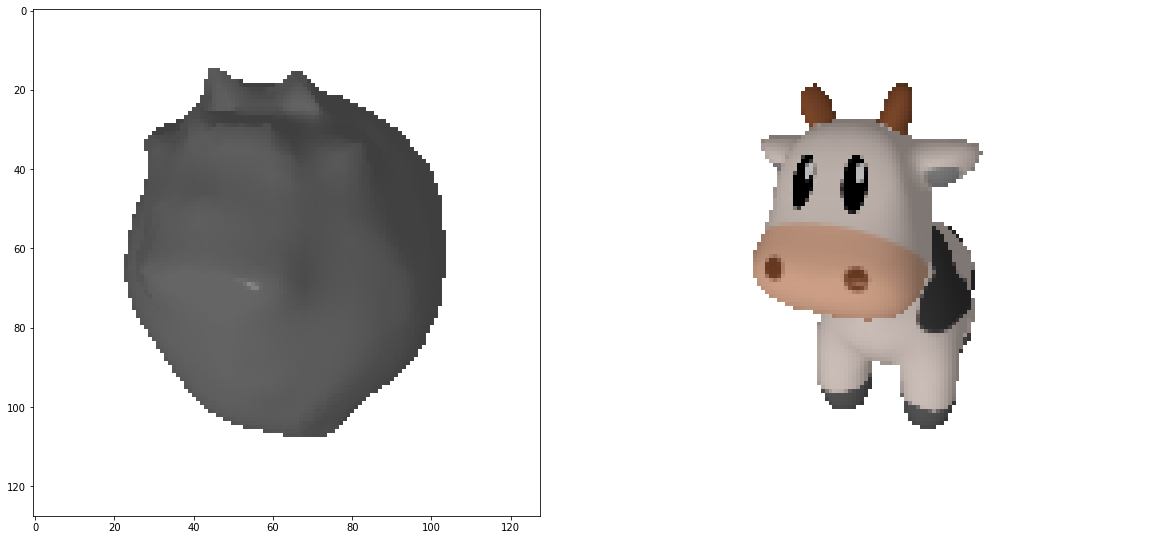

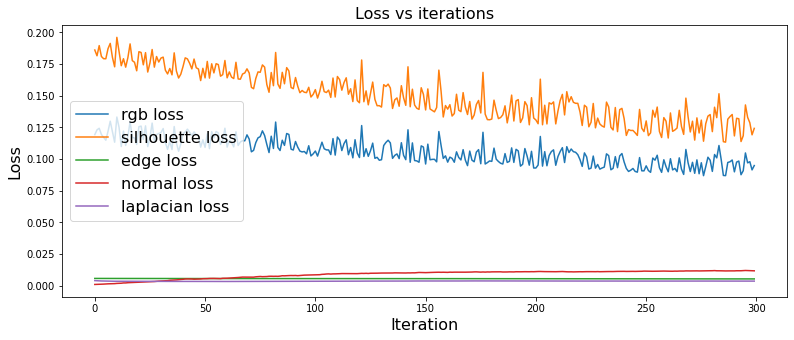

In [ ]:
# from PIL import Image
# import numpy as np


# print(origin_texture.unique())


# newImg = Image.new("RGB", (1024,1024))

# print(origin_texture.unique())


# # new_texture = np.random.randint(0, 255, (1024,1024,3))

# # print(new_texture)
# predicted_texture_numpy = predicted_texture_numpy.astype(np.uint8)
# predicted_texture_numpy = predicted_texture_numpy.reshape((1024,1024,3))

# print(predicted_texture_numpy.shape)
# newImg.paste(Image.fromarray(predicted_texture_numpy), (0,0))
# newImg.save('data/cow_mesh/pred_texture.png')

# # print(new_texture)

# predicted_texture = Image.fromarray
# visualize_prediction(new_src_mesh, renderer=renderer_textured, silhouette=False)
# plot_losses(losses)

Save the final predicted mesh:

## 4. Save the final predicted mesh

In [ ]:
# # Fetch the verts and faces of the final predicted mesh
# final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# # Scale normalize back to the original target size
# final_verts = final_verts * scale + center

# # Store the predicted mesh using save_obj
# final_obj = os.path.join('./', 'final_model.obj')
# save_obj(final_obj, final_verts, final_faces)

## 5. Conclusion
In this tutorial, we learned how to load a textured mesh from an obj file, create a synthetic dataset by rendering the mesh from multiple viewpoints.  We showed how to set up an optimization loop to fit a mesh to the observed dataset images based on a rendered silhouette loss.  We then augmented this optimization loop with an additional loss based on rendered RGB images, which allowed us to predict both a mesh and its texture.